# METABRIC methylation data statistics

In [1]:
source(here::here("scripts/init.R"))

## Breakdown of samples

#### Figure 1A

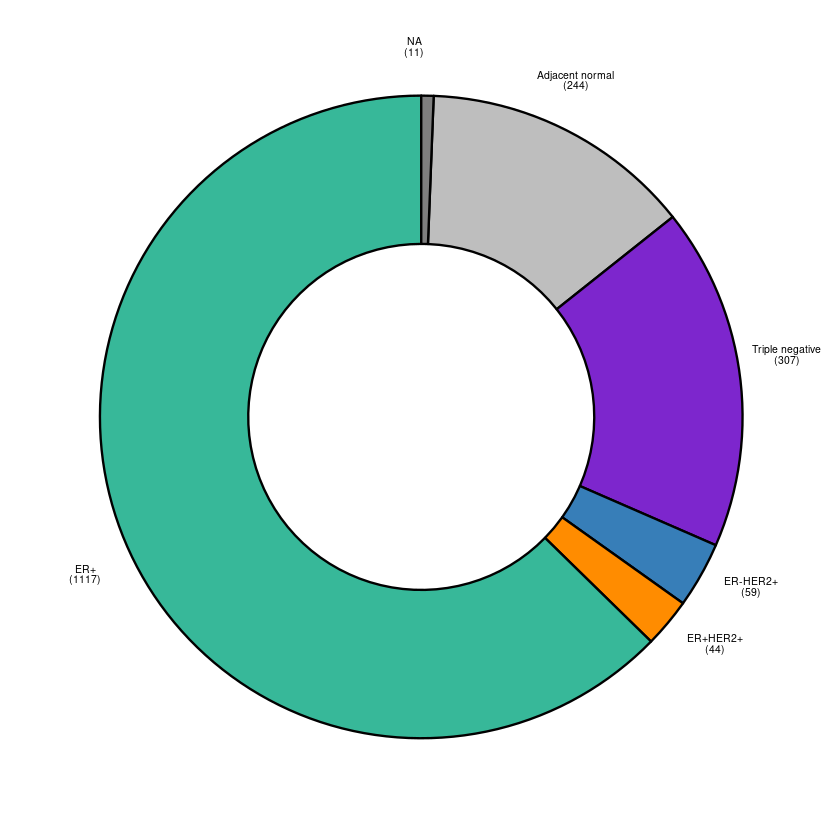

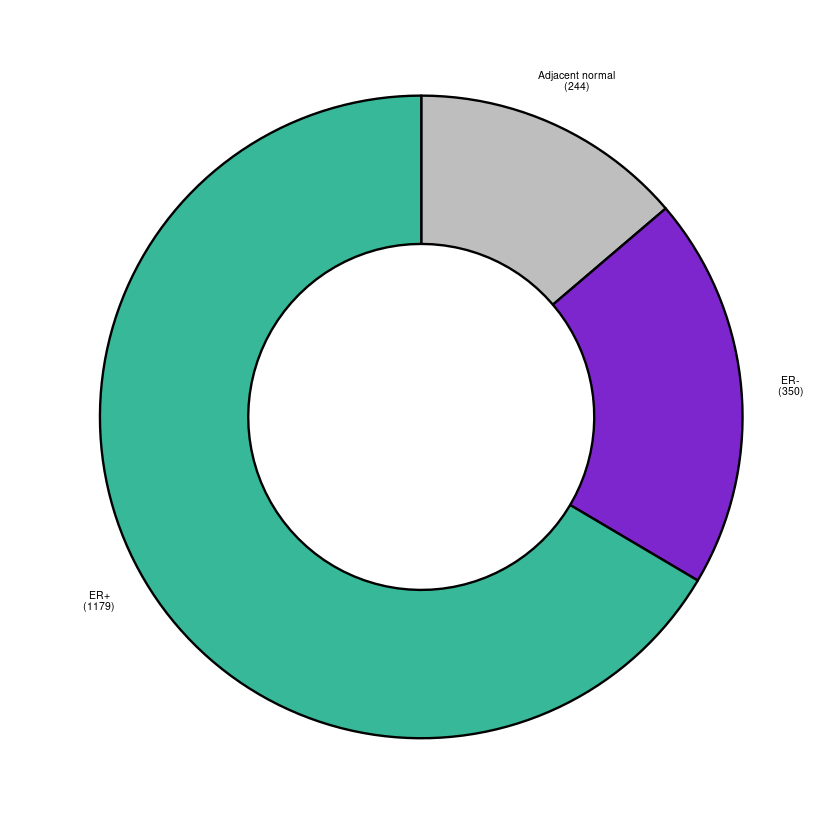

In [2]:
options(repr.plot.width = 7, repr.plot.height = 7)

p_donut <- samp_data %>%
        count(IHC) %>%
        filter(!is.na(IHC)) %>%
        left_join(
            tibble(
                IHC = c("ER+HER2-", "ER+HER2+", "ER-HER2+", "TNBC", "ADJNORMAL"),
                group = c("ER+", "ER+HER2+", "ER-HER2+", "Triple negative", "Adjacent normal")
            ), by = "IHC") %>%
        mutate(
            IHC = factor(IHC, levels = c("ER+HER2-", "ER+HER2+", "ER-HER2+", "TNBC", "ADJNORMAL")),
            lab = glue("{group}\n({n})")
        ) %>%
        ggpubr::ggdonutchart("n", "lab", fill = "IHC", lab.pos = "out", palette = annot_colors$IHC, font.family = "Arial", lab.font = c(6, "bold", "black"), ggtheme = ggpubr::theme_pubr(base_size = 6, base_family = "Arial")) + guides(fill = "none")


p_donut1 <- samp_data %>%
        count(ER1) %>%
        rename(ER = ER1) %>% 
        filter(!is.na(ER)) %>%
        left_join(
            tibble(
                ER = c("ER+", "ER-", "normal"),
                group = c("ER+", "ER-", "Adjacent normal")
            ), by = "ER") %>%
        mutate(
            ER = factor(ER, levels = c("ER+", "ER-", "normal")),
            lab = glue("{group}\n({n})")
        ) %>%
        ggpubr::ggdonutchart("n", "lab", fill = "ER", lab.pos = "out", palette = annot_colors$ER1, font.family = "Arial", lab.font = c(6, "bold", "black"), ggtheme = ggpubr::theme_pubr(base_size = 6, base_family = "Arial")) + guides(fill = "none")

p_donut
p_donut1

## Number of samples

In [3]:
samp_data %>% mutate(ER1 = forcats::fct_explicit_na(ER1)) %>% count(ER1)

ER1,n
<fct>,<int>
ER-,350
ER+,1179
normal,244
(Missing),9


## Total number of reads

In [4]:
tot_reads <- fread(here("data/sample_qc.csv")) %>%     
    inner_join(samp_data %>% 
        select(track), by = "track") %>% 
    pull(total_reads) %>% 
    sum() 

glue("Overall, we used {round(tot_reads / 1e9, digits = 1)}B reads to cover {scales::comma(nrow(samp_data))} breast tumor and normal samples")

Overall, we used 30.4B reads to cover 1,782 breast tumor and normal samples

## Distribution of CpG coverage per sample

We calculate the distribution of every sample's CpG coverage:

In [5]:
samp_covs <- get_samples_coverage_dist(
    tracks = samp_data$track, 
    breaks = c(0:100, 1e5), 
    intervals = gintervals.all()) %cache_df% here("data/sample_coverage_dist.tsv") %>% as_tibble()

In [6]:
samp_covs <- samp_covs %>% left_join(samp_data %>% select(samp, ER = ER1), by = "samp")

#### Figure 1B

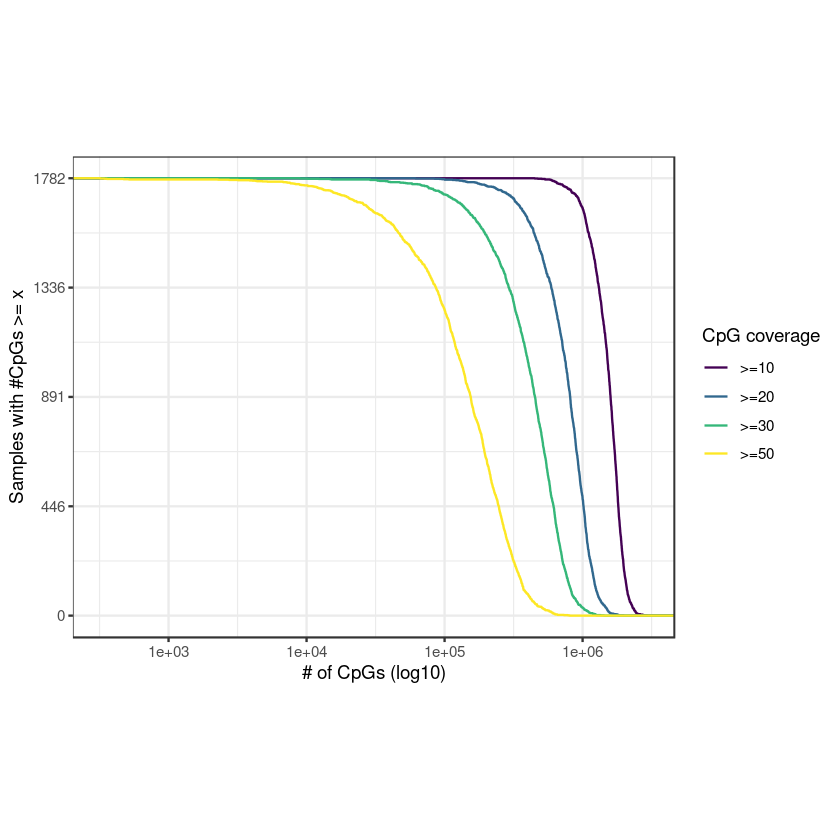

In [7]:
options(repr.plot.width = 7, repr.plot.height = 7)
p_comulative <- samp_covs %>%
        group_by(samp) %>%
        summarise(
            `>=10` = sum(cpgs[cov >= 10]),
            `>=20` = sum(cpgs[cov >= 20]),
            `>=30` = sum(cpgs[cov >= 30]),
            `>=50` = sum(cpgs[cov >= 50]),
            n_tot = sum(cpgs)
        ) %>%
        gather("type", "n", -samp, -n_tot) %>%
        ggplot(aes(x = n, color = type, y = 1 - ..y..)) +
        stat_ecdf() +
        scale_x_log10(labels = scales::scientific) +
        scale_color_viridis_d("CpG coverage") +
        scale_y_continuous(labels = function(x) round(x * length(unique(samp_covs$samp)))) +
        ylab("Samples with #CpGs >= x") +
        xlab("# of CpGs (log10)") +
        theme(aspect.ratio = 0.8)

p_comulative + theme_bw() + theme(aspect.ratio = 0.8)

In [8]:
cov_above_10 <- samp_covs %>% 
    filter(cov >= 10) %>% 
    group_by(samp) %>% 
    summarise(cpgs = sum(cpgs))

df <- cov_above_10 %>%
    summarise(n_threshold = sum(cpgs >= 1e6), n_tot = n()) %>% 
    mutate(p = scales::percent(n_threshold / n_tot))

glue("Number of samples (Y axis) with a given number of CpGs (X axis) covered with at least 10, 20, 30 or 50 reads. For example, in all samples 449,710 CpGs are covered with over 10 reads.", n_cpgs = scales::comma(min(cov_above_10$cpgs)))

glue("Using our version of the RRBS protocol {perc} of the samples were covered by more than 10 reads for more than 1M CpGs", perc = df$p)

Number of samples (Y axis) with a given number of CpGs (X axis) covered with at least 10, 20, 30 or 50 reads. For example, in all samples 449,710 CpGs are covered with over 10 reads.

Using our version of the RRBS protocol 93% of the samples were covered by more than 10 reads for more than 1M CpGs

## Distribution of covered CpGs

We screen for CpGs that are covered by at least 5 reads in half or more of the samples:

In [9]:
min_samples <- round(0.5 * nrow(samp_data))
min_samples

[1] 891

In [10]:
cov_cpgs <- gscreen_coverage(samp_data$track, 5, min_samples) %>% annotate_loci() %cache_df% here("data/cov_cpgs.tsv") %>% as_tibble()

#### Figure 1C

Warning message:
“Removed 147 rows containing non-finite values (stat_density).”


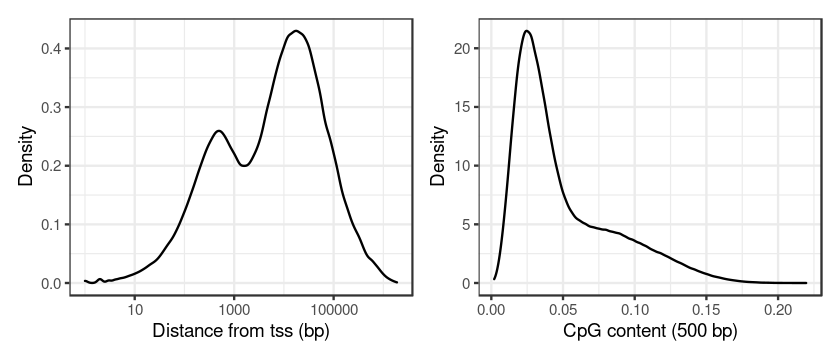

In [11]:
options(repr.plot.width = 7, repr.plot.height = 3)
p_tss <- cov_cpgs %>%
        mutate(tss_d = abs(tss_d) + 1) %>%
        ggplot(aes(x = tss_d)) +
        geom_density() +
        scale_x_log10() +
        xlab("Distance from tss (bp)") +
        ylab("Density")

p_cg_cont <- cov_cpgs %>%
        ggplot(aes(x = cg_cont)) +
        geom_density() +
        xlab("CpG content (500 bp)") +
        ylab("Density")

(p_tss + theme_bw()) + (p_cg_cont + theme_bw())

## Promoter coverage

Distribution of mean promoter coverage over all METABRIC samples, considering 13,282 active promoters. Active promoters were defined as promoters that had log expression >7 in at least one of the METABRIC samples used in this paper.

#### Figure 1D

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 119 rows containing non-finite values (stat_bin).”


[1] 13198

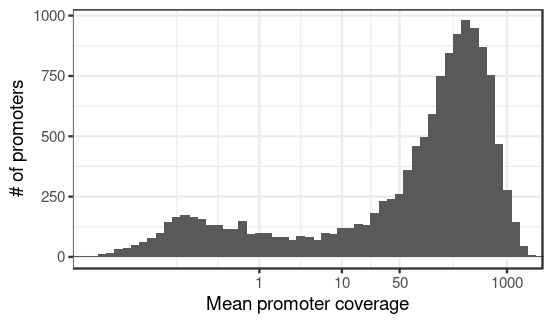

In [12]:
options(repr.plot.width = 4.6, repr.plot.height = 2.7)
prom_expr_cov <- get_promoter_expr_covs()

min_n_expr <- 0
max_expr <- 7

prom_expr_cov_active <- prom_expr_cov %>%
        filter(n_expr > min_n_expr, max_expr > !! max_expr)

p_prom_cov <- prom_expr_cov_active  %>%
        ggplot(aes(x = cov)) +
        geom_histogram(binwidth = 0.1) +
        scale_x_log10(breaks = c(1, 10, 50, 1000), labels = function(x) round(x)) +
        coord_cartesian(xlim = c(0.01,1500)) + 
        ylab("# of promoters") +
        xlab("Mean promoter coverage")

p_prom_cov + theme_bw()
nrow(prom_expr_cov_active)

In [13]:
n_cov <- prom_expr_cov_active %>% filter(cov >= 20) %>% nrow()

glue("{perc} of the promoters were nevertheless covered with over 20 reads on average (mean coverage {cov}), facilitating quantitative analysis downstream.", perc = scales::percent(n_cov / nrow(prom_expr_cov_active)), cov = round(mean(prom_expr_cov_active$cov) ))

75% of the promoters were nevertheless covered with over 20 reads on average (mean coverage 246), facilitating quantitative analysis downstream.

In [14]:
samp_tot_calls <- get_sample_tot_meth_calls() %cache_df% here("data/sample_tot_meth_calls.tsv") %>% as_tibble()
samp_tot_calls_promoters <- get_sample_tot_meth_calls(promoter_intervs) %cache_df% here("data/sample_tot_meth_calls_promoters.tsv") %>% as_tibble()
tot_reads <- sum(samp_tot_calls$Sum)
tot_promoter_reads <- sum(samp_tot_calls_promoters$Sum)
glue("{perc} of the reads mapped to bona-fide promoters", perc = scales::percent(tot_promoter_reads / tot_reads))

9% of the reads mapped to bona-fide promoters

We can also calculate the % of MSP1 fragments that is covering a promoter: 

In [15]:
well_covered_loci <- {
    msp1_meth <- get_msp1_meth()
    msp1_meth_f <- filter_avg_meth(msp1_meth$avg, normal_fraction = 0.7, tumor_fraction = 0.7)
    msp1_meth_f %>% select(chrom, start, end)
} %cache_df% here("data/well_covered_msp1_frags.tsv") %>% as_tibble()

n_loci <- nrow(well_covered_loci)
n_promoters <- well_covered_loci %>% gintervals.neighbors1(promoter_intervs) %>% filter(dist == 0) %>% nrow()

scales::percent(n_promoters / n_loci)

[1] "10%"

## Coverage per clinical annotations

In [16]:
samp_covs <- get_sample_tot_meth_calls() %cache_df% here("data/sample_tot_meth_calls.tsv") %>% as_tibble()
samp_covs <- samp_covs %>%
        select(samp, tot_cov = Sum) %>%
        left_join(samp_data %>% select(samp, stage, grade, iC10, ER = ER1), by = "samp") %>% 
        mutate(stage = ifelse(stage %in% c(0, "DCIS", 1), "0-1", stage)) %>% 
        mutate(stage = ifelse(ER == "normal", "N", stage)) %>% 
        mutate(grade = ifelse(ER == "normal", "N", grade)) %>% 
        mutate(stage = factor(stage, levels = c("N", "0-1", "2", "3", "4"))) %>% 
        mutate(grade = factor(grade, levels = c("N", "1", "2", "3")))        

#### Extended Data Figure 1a

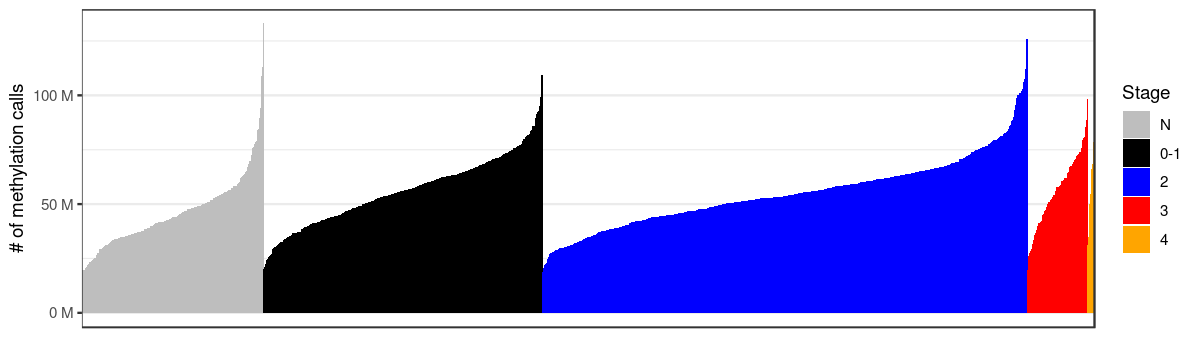

In [17]:
options(repr.plot.width = 10, repr.plot.height = 3)
p_stage <- samp_covs %>%        
        filter(!is.na(stage), !is.na(ER)) %>%        
        arrange(stage, tot_cov) %>%
        mutate(samp = forcats::fct_inorder(samp)) %>%
        ggplot(aes(x = samp, y = tot_cov, fill = stage)) +
        geom_col() +
        theme(axis.ticks.x = element_blank(), axis.text.x = element_blank()) +
        scale_y_continuous(labels = scales::unit_format(unit = "M", scale = 1e-6)) +
        scale_x_discrete(breaks = FALSE) +
        scale_fill_manual(name = "Stage", values = c("N" = "gray", "0-1" = "black", "2" = "blue", "3" = "red", "4" = "orange")) + 
        xlab("") +
        ylab("# of methylation calls")

p_stage + theme_bw() + theme(axis.ticks.x = element_blank(), axis.text.x = element_blank())

#### Extended Data Figure 1b

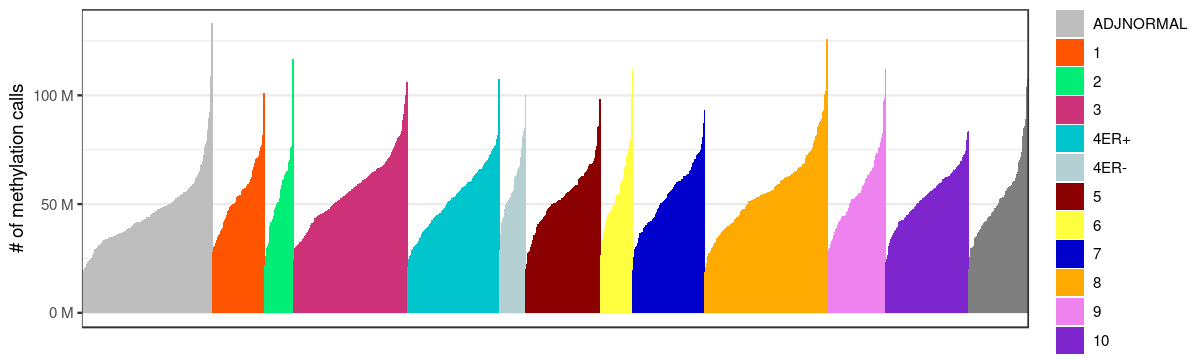

In [18]:
options(repr.plot.width = 10, repr.plot.height = 3)

p_iC10 <- samp_covs %>%
        filter(!is.na(iC10), !is.na(ER)) %>%
        mutate(iC10 = factor(iC10, levels = names(annot_colors$iC10))) %>%
        arrange(iC10, tot_cov) %>%
        mutate(samp = forcats::fct_inorder(samp)) %>%
        ggplot(aes(x = samp, y = tot_cov, fill = iC10)) +
        geom_col() +
        theme(axis.ticks.x = element_blank(), axis.text.x = element_blank()) +
        scale_y_continuous(labels = scales::unit_format(unit = "M", scale = 1e-6)) +
        scale_x_discrete(breaks = FALSE) +
        scale_fill_manual(values = annot_colors$iC10) +
        xlab("") +
        ylab("# of methylation calls")

p_iC10 + theme_bw() + theme(axis.ticks.x = element_blank(), axis.text.x = element_blank())

## Marginal CpG coverage

In [19]:
cpg_mars <- covs_marginal(samp_data$track) %cache_df% here("data/cpg_cov_marginal.tsv") %>% as_tibble()

In [20]:
cpg_mars <- cpg_mars %>% mutate(mean_cov = cov / nrow(samp_data))
cov_cdf <- map_df(c(0:100, seq(200, 1000, 20)), ~ tibble(cov = .x, n = sum(cpg_mars$mean_cov >= .x)))  %cache_df% here("data/cpg_cov_cdf.tsv") %>% as_tibble()

#### Extended Data Figure 1b

Warning message:
“Transformation introduced infinite values in continuous y-axis”


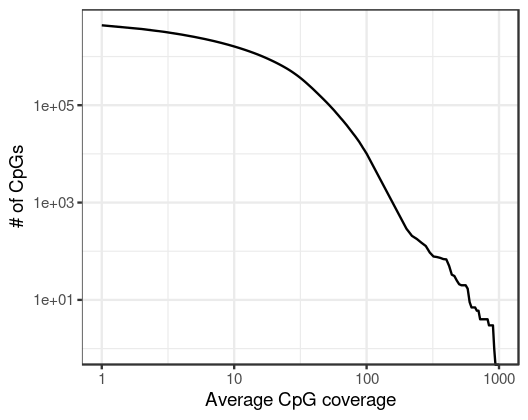

In [21]:
options(repr.plot.width = 4.4, repr.plot.height = 3.5)

p_cov_cdf <- cov_cdf %>%
        filter(cov >= 1) %>%
        ggplot(aes(x = cov, y = n)) +
        geom_line() +
        scale_y_log10(labels = scales::scientific) +
        scale_x_log10() +
        xlab("Average CpG coverage") +
        ylab("# of CpGs")

p_cov_cdf + theme_bw() 

### Marginal CpG coverage of k4me1 hotspots

In [22]:
conf <- main_config$genomic_regions$enhancers

conf$H3K4me1_tracks
conf$H3K4me1_thresh
conf$H3K4me1_size

intervs <- gpatterns.putative_enhancers(conf$H3K4me1_tracks, quant_thresh = conf$H3K4me1_thresh, normalize = conf$H3K4me1_size, min_tss_dist = conf$H3K4me1_tss_dist)
k4me1_mars <- cpg_mars %>%
    gintervals.neighbors1(intervs) %>%
    filter(dist == 0) %>%
    group_by(chrom1, start1, end1) %>%
    summarise(cov = sum(cov), mean_cov = cov / nrow(samp_data))
k4me1_mars <- k4me1_mars %>%
    ungroup() %>%
    select(chrom = chrom1, start = start1, end = end1, cov, mean_cov)

[1] "Roadmap.Breast_Luminal_Epithelial_Cells.H3K4me1"      
[2] "Roadmap.Breast_Myoepithelial_Cells.H3K4me1_1"         
[3] "Roadmap.Breast_Myoepithelial_Cells.H3K4me1_2"         
[4] "encode.Tfbs.HMECwgEncodeBroadHistoneHmecH3k4me1StdSig"

[1] 0.97

[1] 200

#### Extended Data Figure 1c

Warning message:
“Transformation introduced infinite values in continuous y-axis”


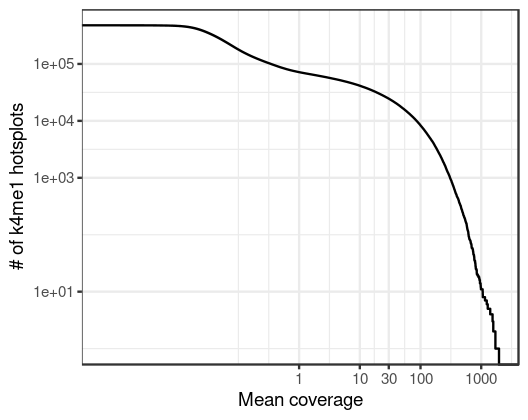

In [23]:
options(repr.plot.width = 4.4, repr.plot.height = 3.5)

p_k4me1 <- k4me1_mars %>%
        ggplot(aes(x = mean_cov, y = (1 - ..y..) * nrow(k4me1_mars))) +
        stat_ecdf() +
        scale_y_log10(labels = scales::scientific, breaks = c(10, 1e3, 1e4, 1e5)) +
        scale_x_log10(breaks = c(1, 10, 30, 100, 1000)) +
        xlab("Mean coverage") +
        ylab("# of k4me1 hotsplots") +
        vertical_labs()

p_k4me1 + theme_bw()

In [24]:
k4me1_mars <- cpg_mars %>%
    gintervals.neighbors1(enh_intervs_tumors) %>%
    filter(dist == 0) %>%
    group_by(chrom1, start1, end1) %>%
    summarise(cov = sum(cov), mean_cov = cov / nrow(samp_data))
k4me1_mars <- k4me1_mars %>%
    ungroup() %>%
    select(chrom = chrom1, start = start1, end = end1, cov, mean_cov)

Warning message:
“Transformation introduced infinite values in continuous y-axis”


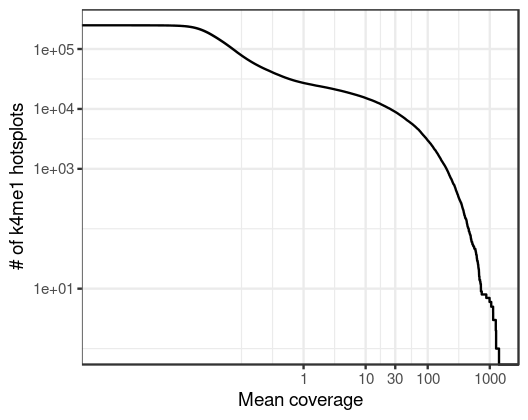

In [25]:
options(repr.plot.width = 4.4, repr.plot.height = 3.5)

p_k4me1_tumors <- k4me1_mars %>%
        ggplot(aes(x = mean_cov, y = (1 - ..y..) * nrow(k4me1_mars))) +
        stat_ecdf() +
        scale_y_log10(labels = scales::scientific, breaks = c(10, 1e3, 1e4, 1e5)) +
        scale_x_log10(breaks = c(1, 10, 30, 100, 1000)) +
        xlab("Mean coverage") +
        ylab("# of k4me1 hotsplots") +
        vertical_labs()

p_k4me1_tumors + theme_bw()

## Sample cellularity

#### Extended Data Figure 1d

Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 279 rows containing missing values (geom_point).”


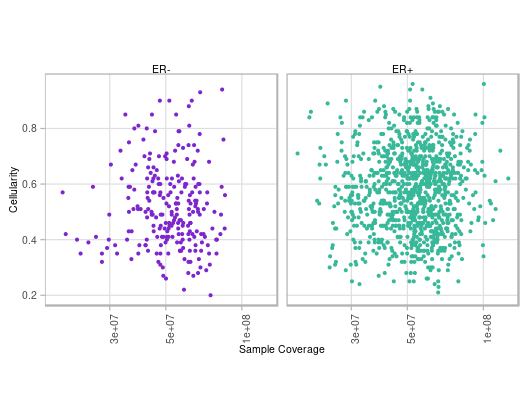

In [26]:
p_cellularity_cov <- samp_covs %>%
        filter(!is.na(ER)) %>%
        left_join(samp_data %>% select(samp, cna_cellularity)) %>%
        slice(sample(1:n())) %>%
        filter(ER != "normal") %>% 
        ggplot(aes(x = tot_cov, y = cna_cellularity, color = ER)) + 
            geom_point(size=0.1) + 
            scale_color_manual(values = annot_colors$ER1) + 
            scale_x_log10() + 
            theme(aspect.ratio = 1) + 
            guides(color = FALSE) + 
            xlab("Sample Coverage") + 
            ylab("Cellularity") + 
            vertical_labs() + 
            facet_grid(.~ER)

p_cellularity_cov

Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“Removed 279 rows containing missing values (geom_point).”


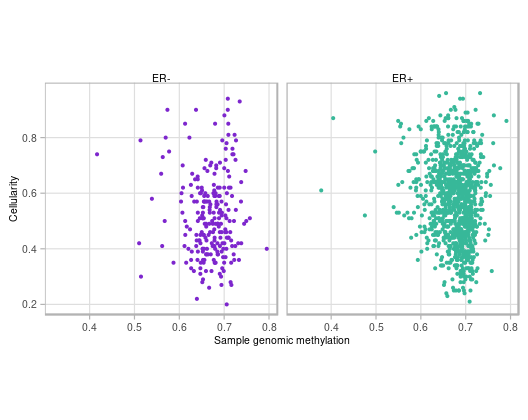

In [27]:
samp_genomic_meth <- get_genomic_avg_meth() %>% intervs_to_mat() %>% colMeans(na.rm=TRUE) %>% enframe("samp", "meth") %cache_df% here("data/samp_genomic_meth.tsv") %>% as_tibble()

p_cellularity_meth <- samp_genomic_meth %>%
        left_join(samp_data %>% select(samp, cna_cellularity, ER = ER1)) %>%
        filter(!is.na(ER)) %>%        
        slice(sample(1:n())) %>%
        filter(ER != "normal") %>% 
        ggplot(aes(x = meth, y = cna_cellularity, color = ER)) + 
        geom_point(size=0.1) + 
        scale_color_manual(values = annot_colors$ER1) + 
        theme(aspect.ratio = 1) + 
        guides(color = FALSE) + 
        xlab("Sample genomic methylation") + 
        ylab("Cellularity") + 
        facet_grid(.~ER)

p_cellularity_meth

In [ ]:
gc()